# Working with Gaia archive

Gaia DR2 reports results on measurements for 1.7 billion objects. However, these results are varying levels of quality.  This notebook is designed to examine the impact of data quality on parameters we are interested in.

This notebook will argue for certain data quality cuts to be considered before working with any Gaia results.

Begin by importing all the things.

In [1]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')
from astroquery.gaia import Gaia
from matplotlib import pyplot as plt
import time
from scipy.optimize import brentq
from scipy.stats.mstats import mquantiles
from scipy.stats import norm

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### The sample - the first 1M stars in the catalog with the largest parallaxes
Using ESO's TAP connection and the astroquery python interface, I performed the following query of the Gaia database.  I searched for the top 1M returns of largest parallax (less than 800 mas - The Gaia archive does include objects in our solar system, so I restricted my search to things at least as far as Proxima Centauri), ordered by decreasing parallax value, and dumped them out to a file.

* Warning - don't run this cell unless you actually want to do your own search.  This query takes little more than an hour to run.

In [3]:
start = time.time()
job = Gaia.launch_job_async(query="SELECT TOP 1000000 * FROM gaiadr2.gaia_source WHERE parallax <= 800 \
                    ORDER BY parallax DESC",\
                    verbose=False, dump_to_file=True, output_format='csv')
print job

end = time.time()
print(end - start)

Jobid: 1531159425048O
Phase: COMPLETED
Owner: None
Output file: async_20180709110345.csv
Results: None
4057.95173407


Input the results.

In [2]:
k = pd.read_csv('async_20180709110345.csv')

Some of the Gaia sources include a full stellar parameter estimate (well, full for DR2.  DR3 will include more stellar parameters), including Teff, luminosity, radius, line-of-sight extinction, and radial velocity.  These parameters were estimated using Apsis ( described here http://www.mpia.de/homes/calj/gdr2_apsis.pdf), an algorithm for robustly characterizing these parameters.  However, as described in that reference, these values are subject to large systematics which are well understood but can't be eliminated.  And, only a small fraction of the sources could these be estimated for.  Data quality, among others, was the largest factor for if these parameters could be estimated.  

Let's look at this sample:

In [3]:
print 'How many sources do not have parallax solutions:',np.where(np.isnan(k['parallax']))[0].shape[0]
print 'max parallax:',np.max(k['parallax'].values)*u.mas,'min parallax:',np.min(k['parallax'].values)*u.mas
print ''
print 'How many sources don\'t have:'
print 'Teff',np.where(np.isnan(k['teff_val']))[0].shape[0]
print 'Lum',np.where(np.isnan(k['lum_val']))[0].shape[0]
print 'RV',np.where(np.isnan(k['radial_velocity']))[0].shape[0]
print 'Radius',np.where(np.isnan(k['radius_val']))[0].shape[0]
print 'Gmag',np.where(np.isnan(k['phot_g_mean_mag']))[0].shape[0]
print 'Gbp-Grp mag',np.where(np.isnan(k['bp_rp']))[0].shape[0]

How many sources do not have parallax solutions: 0
max parallax: 796.124431419 mas min parallax: 8.94966556929 mas

How many sources don't have:
Teff 678622
Lum 904480
RV 902433
Radius 904480
Gmag 0
Gbp-Grp mag 152451


So all have parallax and G band photometry, about 30% have Teff, 10% have the full Apsis solution.  Most have Gbp-Grp, which is the Gaia bandpass colors.

Let's remove all sources without color information, since that's not very many, and its very important:

In [4]:
m=k.drop(np.where(np.isnan(k['bp_rp']))[0],axis=0)
m=m.reset_index()
m = m.drop(['index'], axis=1)
#m

### Data Quality

The main parameter we are interested in in determining data quality is the fractional parallax error:  f = parallax error/parallax.  A smaller value means the error is a smaller proportion of the value of the parallax, and thus a better quality parallax solution.  (There is a parameter in the Gaia solution called "parallax_over_error", which is the inverse of the fractional parallax error, and so an equally good measure of quality, with larger values being better quality.  Some literature use f while some use parallax_over_error; I will make use of both here)

Max and min f: 0.605316790776 8.85532734304e-05
Number above 0.1: 314098


<IPython.core.display.Javascript object>


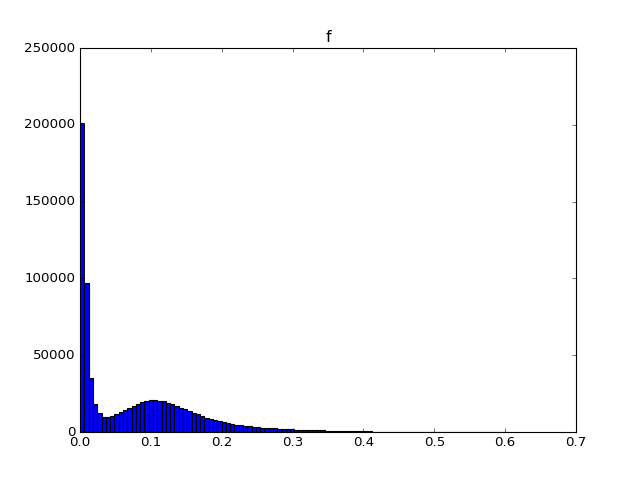

In [5]:
frac_para_error = m['parallax_error'].values/m['parallax'].values

print 'Max and min f:',np.max(frac_para_error),np.min(frac_para_error)
print 'Number above 0.1:',np.where(frac_para_error>0.1)[0].shape[0]

%matplotlib notebook
plt.hist(frac_para_error,bins=100)
plt.title('f')
plt.show()

So most have f<0.1, while some extend to just at f=0.4.  Let's see the effect the value of f has on the results.

### Distance
For a comprehensive discussion on how to compute distance and FWHM and sigma, see my Jupyter notebook "Computing Gaia Distances", and the references contained therein.

This script uses that methodolgy to compute distance and FWHM for every source. (Warning - takes a long time to run)
* Note - Gaia parallaxes have a zero-point shift of -0.029 mas. So 0.029 mas must be added to the measured parallax to get accurate distances. (Luri et. al. 2018 (https://arxiv.org/abs/1804.09376))  Also, the parallax must be converted to arcseconds to get the distance in parcsecs.

In [16]:
# Set scale length for prior:
L=1350 #parsecs

start = time.time()

omega,sigma = (m['parallax'].values+0.029)/1000,m['parallax_error'].values/1000
gdist = np.array([])

print 'Computing distances'
count=0
for i in range(len(omega)):
    coeff = np.array([(1./L),(-2),((omega[i])/((sigma[i])**2)),-(1./((sigma[i])**2))])
    g = np.roots(coeff)
    # Find the number of real roots:
    reals = np.isreal(g)
    realsum = np.sum(reals)
    # If there is one real root, that root is the  mode:
    if realsum == 1:
        gd = np.real(g[np.where(reals)[0]])
    # If all roots are real:
    elif realsum == 3:
        if omega[i] >= 0:
            # Take the smallest root:
            gd = np.min(g)
        elif omega[i] < 0:
            # Take the positive root (there should be only one):
            gd = g[np.where(g>0)[0]]
    gdist = np.append(gdist,gd)
    
    count = count+1
    mod=count%100000
    if mod==0:
        print 'Finished ',count,' sources'
print 'Finished distances for ',gdist.shape[0]

end = time.time()
print(end - start)

print 'Computing FWHM'

count=0
rmax = 1e6
fwhm_lo,fwhm_hi = np.array([]),np.array([])
for i in range(len(omega)):
    rmode = gdist[i]
    M = (rmode**2*np.exp(-rmode/L)/sigma[i])*np.exp((-1./(2*(sigma[i])**2))*(omega[i]-(1./rmode))**2)
    lo = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), 0.001, rmode)
    hi = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), rmode, rmax)
    fwhm_lo,fwhm_hi = np.append(fwhm_lo,lo),np.append(fwhm_hi,hi)
    
    count = count+1
    mod=count%100000
    if mod==0:
        print 'Finished ',count,' sources'

print 'Finished FWHM for ',fwhm_lo.shape[0]
end = time.time()
print(end - start)

Computing distances
Finished  100000  sources
Finished  200000  sources
Finished  300000  sources
Finished  400000  sources
Finished  500000  sources
Finished  600000  sources
Finished  700000  sources
Finished  800000  sources
Finished distances for  847549
1084.64976096
Computing FWHM
Finished  100000  sources
Finished  200000  sources
Finished  300000  sources
Finished  400000  sources
Finished  500000  sources
Finished  600000  sources
Finished  700000  sources
Finished  800000  sources
Finished FWHM for  847549
3398.09066892


<IPython.core.display.Javascript object>


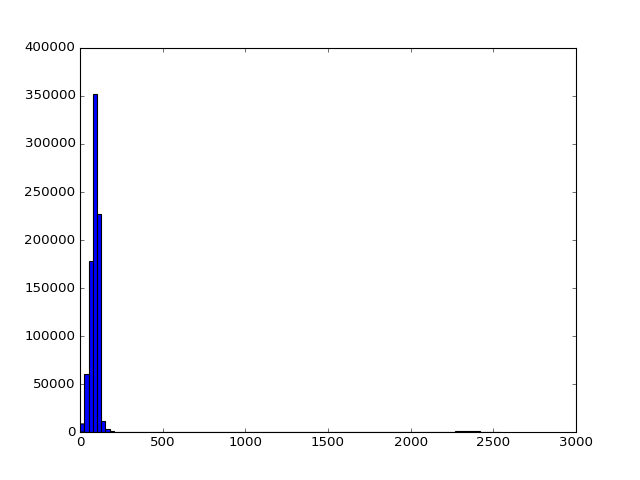

In [18]:
%matplotlib notebook
plt.hist(gdist,bins=100)
plt.show()

Most are clustered where we would expect them, but there are a few at higher values of distance.  This will be shown to be more of a problem as we go on.

#### Uncertainty on distance
Computing the uncertainty is difficult and computationalls intensive if you have a lot of sources with f>0.1 or so.  See the jupyter notebook tutorial "Computing distance with Gaia parallaxes tutorial" for a detailed discussion of how to do it properly, and why it fails for large values of f.  So for now, I will just import a file for which this has already been done on these sources and proceed from there.

In [10]:
master=pd.read_csv('Nearest_1M_stars.csv')

### Properties of this sample:

Let's look at a plot of these objects on the sky:

<IPython.core.display.Javascript object>


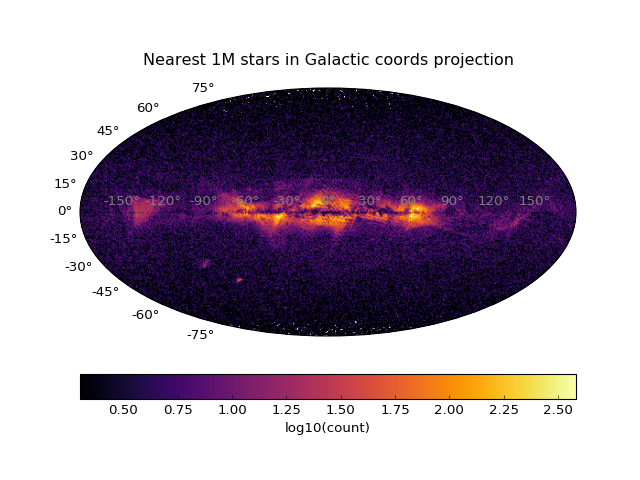

In [4]:
import astropy.coordinates as coord
pl = coord.Angle(master['l'].values*u.degree)
pl = pl.wrap_at(180*u.degree)
pb = coord.Angle(master['b'].values*u.degree)

%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
hb = ax.hexbin(pl.radian, pb.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.scatter(pra.radian, pdec.radian,alpha=0.2,color='blue',s=5)
#ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.set_title('Nearest 1M stars in Galactic coords projection\n')
ax.tick_params(axis='x', colors='grey')
cb = fig.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()


This looks really pretty.  But... it's supposed to be the nearest 1M stars.  We should not be seeing the Galactic center and the LMC/SMC, those are much further away than 150 pc or so.  This is a problem.  It should look like a nearly constant density in all directions.

If we drop sources from the sample with high values of f (low values of parallax_over_error), lets see what we get:

<IPython.core.display.Javascript object>


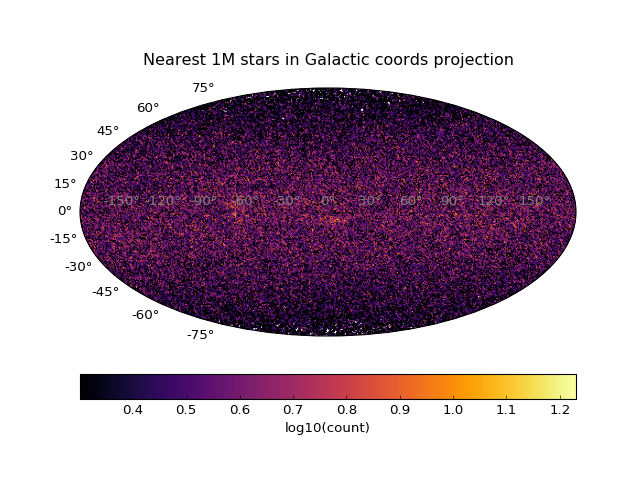

In [6]:
import astropy.coordinates as coord
# Drop sources with f>0.025
o=master.drop(np.where(master['parallax_over_error'].values<40)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)

pl = coord.Angle(o['l'].values*u.degree)
pl = pl.wrap_at(180*u.degree)
pb = coord.Angle(o['b'].values*u.degree)

%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
hb = ax.hexbin(pl.radian, pb.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.scatter(pra.radian, pdec.radian,alpha=0.2,color='blue',s=5)
#ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.set_title('Nearest 1M stars in Galactic coords projection\n')
ax.tick_params(axis='x', colors='grey')
cb = fig.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()
plt.savefig('nearest_1M_gal_mollweide_highqualitycut.jpg')

That's what I'd expect.  Looking good.

Let's switch to looking at the color-magnitude diagram for this sample.

<IPython.core.display.Javascript object>


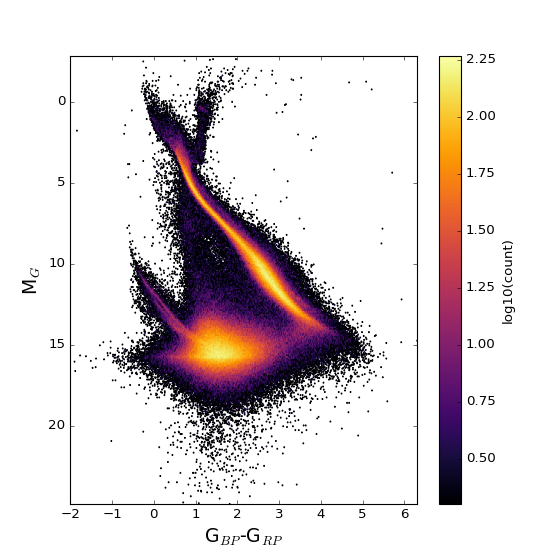

In [8]:
final=m
# GBP - GRP color:
color = final['bp_rp'].values
# Apparent G band magnitude:
gmag = final['phot_g_mean_mag'].values 

# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(final['parallax'].values/1000)

%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
#fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)

#ax = axs[0]
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$',fontsize=17)
ax.set_xlabel('G$_{BP}$-G$_{RP}$',fontsize=17)
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')

plt.show()
plt.savefig('Nearest_1M_nocut.png',format='png',dpi=300)

Beautiful - except what's with all those sources in the bottom middle?  I don't recall learning about that stellar population... because there isn't one.  This is non-physcial.  Is it just data quality?

Let's drop sources with f>0.05.

<IPython.core.display.Javascript object>


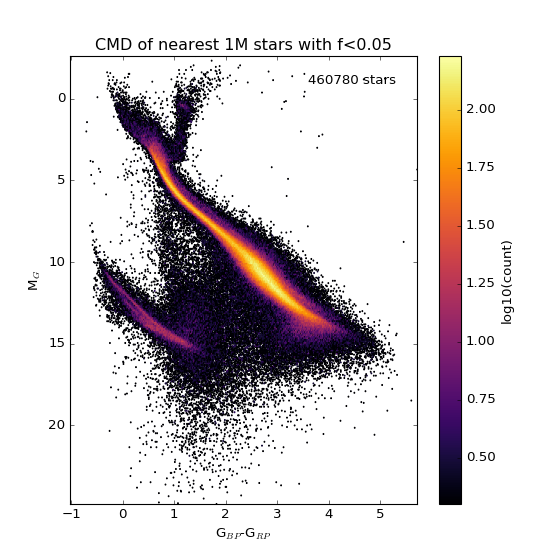

In [24]:
cut = 20
o=final.drop(np.where(final['parallax_over_error'].values<cut)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars with f<{0}".format(np.round(1./cut,decimals=3)))
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.annotate('{0} stars'.format(o.shape[0]),xy=(0.55,0.85),xycoords='figure fraction')
plt.show()

Most of those sources are gone.  There's still a bunch in the middle of the CMD though that don't belong.  Trying a deeper cut:

<IPython.core.display.Javascript object>


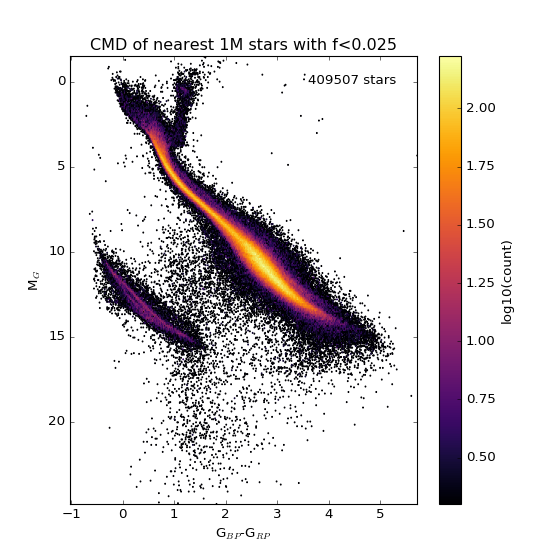

In [25]:
cut = 40
o=final.drop(np.where(final['parallax_over_error'].values<cut)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars with f<{0}".format(np.round(1./cut,decimals=3)))
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.annotate('{0} stars'.format(o.shape[0]),xy=(0.55,0.85),xycoords='figure fraction')
plt.show()

Now that looks much better!  So just restricting the parallax error solves almost all the problems.

## Enter the Gaia Coll. HRD
The Gaia collaboration produced their own HR daigram, discussed here: https://arxiv.org/pdf/1804.09378.pdf <br>
They attempted to select the highest quality data to make their HRD, and so made several quality filters they describe in detail in this paper.  I will apply them 1 by 1 and see the effect.

The Gaia paper however does use a parallax cut of f>0.1.  I've shown that that doesn't seem to quite be enough.  I will use f>0.05 cut.

(460780, 101)
(444533, 101)
(389236, 101)
(360788, 101)


<IPython.core.display.Javascript object>


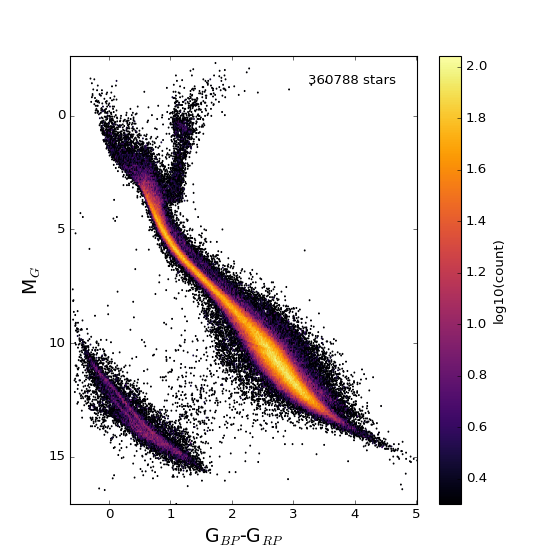

In [12]:
# Cut poor parallax quality results:
cut = 20
o=master.drop(np.where(master['parallax_over_error'].values<cut)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

# Use results only with a high number of observations to decrease noise:
o=o.drop(np.where(o['visibility_periods_used'].values<8)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
print o.shape

# Use results with high quality G band photometry measurements:
o=o.drop(np.where(o['phot_g_mean_flux_over_error'].values<50)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
o=o.drop(np.where(o['phot_rp_mean_flux_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
o=o.drop(np.where(o['phot_bp_mean_flux_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

# Use results with good chi2 relative to G-band magnitude:
v1 = np.sqrt(o['astrometric_chi2_al'].values/(o['astrometric_n_good_obs_al'].values-5))
v2=np.zeros(len(v1))
for i in range(len(v1)):
    v2[i] = 1.2*max(1,np.exp(-0.2*(o['phot_g_mean_mag'].values[i]-19.5)))
o=o.drop(np.where(v2<v1)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
print o.shape

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.set_title("CMD of nearest 1M stars with f<{0}".format(np.round(1./cut,decimals=3)))
ax.set_ylabel('M$_{G}$',fontsize=17)
ax.set_xlabel('G$_{BP}$-G$_{RP}$',fontsize=17)
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.annotate('{0} stars'.format(o.shape[0]),xy=(0.55,0.85),xycoords='figure fraction')
plt.show()
plt.savefig('nearest_1M_CMD_highestqualitycut.png',format='png',dpi=300)

Wow, that is a nice looking CMD.  You can even see the two bands in the WDs, two bands in the M dwarfs, and the cut around M=10 that corresponds to where M dwarfs transition from partially to fully convective (here is a paper discussing that this was discovered $\textit{because}$ of the high quality of Gaia measurements: http://arxiver.moonhats.com/2018/06/21/a-gap-in-the-lower-main-sequence-revealed-by-gaia-data-release-2-ssa/ )

# Conclusion:
The low quality sources really aren't worth the time it takes to mess with them.  They're results are always unreliable for anything you could ask of them.  It is best to start from an initial sample excluding those problem sources.  Applying the cuts used to make the CMD above yields 31M sources remaining in the catalog (of the 1.7B sources).  This is a huge amount of objects remaining to work with, without wasting time on the ones we'll just throw out in the end.

Here is a sample query that applies all these filters above.  It is taken directly from appendix B in the HRD paper.  the only change is that I used parallax_over_error > 20 while they use 10.  This takes the total number of sources fitting the criteria from 65M to 31M.

In [ ]:

job = Gaia.launch_job_async(query="SELECT * FROM gaiadr2.gaia_source \
    WHERE parallax_over_error > 20 \
    AND phot_g_mean_flux_over_error>50 \
    AND phot_rp_mean_flux_over_error>20 \
    AND phot_bp_mean_flux_over_error>20 \
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
    AND visibility_periods_used>=8 AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))",\
                    verbose=False, dump_to_file=True, output_format='csv')

This cell counts the number of archive entries meeting the cut criteria.

In [27]:
job = Gaia.launch_job_async(query="SELECT COUNT(*) \
    FROM gaiadr2.gaia_source \
    WHERE parallax_over_error > 20 \
    AND phot_g_mean_flux_over_error>50 \
    AND phot_rp_mean_flux_over_error>20 \
    AND phot_bp_mean_flux_over_error>20 \
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
    AND visibility_periods_used>=8 AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))",\
                    verbose=False, dump_to_file=False, output_format='csv')
b=job.get_results()
b

Query finished.


count_all
int64
31415174


In [39]:
f=sigma/omega
index1=100
index2=800000
index3=999996
print f[index1],f[index2],f[index3]
print np.where((omega>=0.0099)&(omega<=0.01))[0]
print f[np.where((omega>=0.0099)&(omega<=0.01))]

0.00265896446731 0.141341491137 0.309635304551
[700006 700007 700008 ..., 722979 722980 722981]
[ 0.12335282  0.13467676  0.09543976 ...,  0.17625776  0.00540638
  0.17700604]


<IPython.core.display.Javascript object>


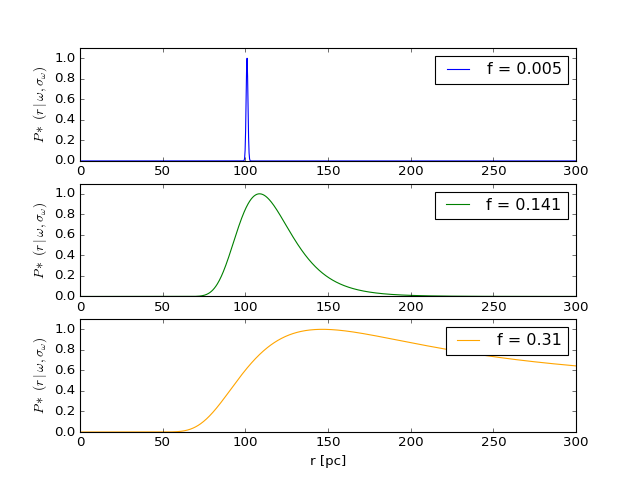

In [42]:
L=1350
omega,sigma = k['parallax'].values/1000,k['parallax_error'].values/1000
f=sigma/omega
index1=722980
index2=800000
index3=999996

%matplotlib notebook
plt.subplot(311)
r = np.linspace(1,300,1e3-1)
post1 = (r**2*np.exp(-r/L)/sigma[index1])*np.exp((-1/(2*(sigma[index1])**2))*(omega[index1]-(1/r))**2)
plt.plot(r,post1/np.max(post1),label='f = {0}'.format(np.round(f[index1],decimals=3)))
#plt.annotate('omega = {0}'.format(np.round(omega[index1]),decimals=3),xy=(0.7,0.8),xycoords="figure fraction")
plt.legend()
plt.ylim(0,1.1)
plt.ylabel('$P*\;(r \mid \omega , \sigma_{\omega})$')

plt.subplot(312)
r = np.linspace(1,300,1e3-1)
post2 = (r**2*np.exp(-r/L)/(sigma[index2]))*np.exp((-1/(2*(sigma[index2])**2))*(omega[index2]-(1/r))**2)
plt.plot(r,post2/np.max(post2),label='f = {0}'.format(np.round(f[index2],decimals=3)),color='green')
plt.legend()
plt.ylim(0,1.1)
plt.ylabel('$P*\;(r \mid \omega , \sigma_{\omega})$')

plt.subplot(313)
r = np.linspace(1,300,1e3-1)
post3 = (r**2*np.exp(-r/L)/(sigma[index3]))*np.exp((-1/(2*(sigma[index3])**2))*(omega[index3]-(1/r))**2)
plt.plot(r,post3/np.max(post3),label='f = {0}'.format(np.round(f[index3],decimals=3)),color='orange')
plt.ylim(0,1.1)
plt.legend()
plt.ylabel('$P*\;(r \mid \omega , \sigma_{\omega})$')
plt.xlabel('r [pc]')
plt.ylim(0,1.1)
plt.show()
plt.savefig('dist_wrt_f.png',format='png',dpi=300)